# Caso de Negocio: Estimación de Costos de Equipos para Proyecto de Construcción

## Importacion de librerias, lectura y procesamiento de los datos

In [ ]:
## IMPORTACION DE LIBRERIAS GENERALES

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import model_selection
from sklearn import neural_network
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numbers import Number


In [ ]:
# Ruta de la carpeta donde están los archivos
carpeta = ""#notebook en la carpeta donde están los datos, en caso contrario incluir entre las comillas el camino de la carpeta donde se hayan.

# Nombres de los archivos
archivos = ["X.csv", "Y.csv", "Z.csv"]

# Leer cada archivo y guardarlo en un dataframe con el delimitador adecuado
df_X = pd.read_csv(f"{carpeta}{archivos[0]}", sep=",", header=0)
df_Y = pd.read_csv(f"{carpeta}{archivos[1]}", sep=";", header=0)
df_Z = pd.read_csv(f"{carpeta}{archivos[2]}", sep=",", header=0)


In [ ]:
### FUNCION PARA LIMPIEZA DE DATAFRAMES

def procesar_dataframe(df, date_col, price_col, date_format):
    # Renombrar columnas para uniformidad
    df = df.rename(columns={date_col: "Date", price_col: "Price"})

    # Formatear la columna de fecha al formato estándar YYYY-MM-DD
    df["Date"] = pd.to_datetime(df["Date"], format=date_format, errors="coerce")

    # Limpiar y convertir la columna de precio a float
    df["Price"] = df["Price"].replace(",", "", regex=True).astype(float)

    return df

In [ ]:
### PROCESAMIENTO DE DATAFRAMES

# Procesar cada DataFrame
df_X = procesar_dataframe(df_X, date_col="Date", price_col="Price", date_format="%Y-%m-%d")
df_Y = procesar_dataframe(df_Y, date_col="Date", price_col="Price", date_format="%d/%m/%Y")
df_Z = procesar_dataframe(df_Z, date_col="Date", price_col="Price", date_format="%Y-%m-%d")

# Renombrar las columnas de precio para fusionar
df_X = df_X.rename(columns={"Price": "Price_X"})
df_Y = df_Y.rename(columns={"Price": "Price_Y"})
df_Z = df_Z.rename(columns={"Price": "Price_Z"})

# Combinar los DataFrames por fecha
df_merged = pd.merge(df_X, df_Y, on="Date", how="outer")
df_merged = pd.merge(df_merged, df_Z, on="Date", how="outer")


Se buscan los valores nulos dentro de df_merge, los cuales se generan al unir los datos de cada materia prima.

In [ ]:
df_merged.isna().sum()

,0
Date,0
Price_X,49
Price_Y,4708
Price_Z,5628


Debido a la cantidad de datos nulos, se eliminaran para contar solo con los dias que si aportan al precio del equipo 1 y 2.

In [ ]:
df_merged = df_merged.sort_values("Date").reset_index(drop=True)
df_merged.dropna(inplace=True)
df_merged=df_merged.set_index('Date')
df_merged.head()

,Price_X,Price_Y,Price_Z
Date,,,
2010-01-04,80.12,5275.0,2225.25
2010-01-05,80.59,5275.0,2246.50
2010-01-06,81.89,5275.0,2302.50
2010-01-07,81.51,5275.0,2306.50
2010-01-08,81.37,5525.0,2261.25


In [ ]:
df_merged.isna().sum()

,0
Price_X,0
Price_Y,0
Price_Z,0


In [ ]:
# Agrupar por "Year-Month" y calcular los valores promedio para cada columna de precio
# Crear la columna "Year-Month" a partir de la fecha del índice
df_merged["Year-Month"] = df_merged.index.strftime("%Y-%m")

# Ahora sí, agrupar por "Year-Month"
df_monthly_avg = df_merged.groupby("Year-Month").mean(numeric_only=True).reset_index()

# Renombrar las columnas para que coincidan con el formato deseado
df_monthly_avg = df_monthly_avg.rename(
    columns={
        "Year-Month": "Date",
        "Price_X": "avg_price_X",
        "Price_Y": "avg_price_Y",
        "Price_Z": "avg_price_Z",
    }
)

# Formatear "Date" como un string para mejorar la presentación
df_monthly_avg["Date"] = df_monthly_avg["Date"].astype(str)
df_monthly_avg.head()

,Date,avg_price_X,avg_price_Y,avg_price_Z
0,2010-01,77.013000,2983.750000,2234.325000
1,2010-02,74.790000,1514.500000,2048.575000
2,2010-03,79.931304,1746.304348,2204.130435
3,2010-04,85.753810,2145.476190,2313.083333
4,2010-05,76.997619,2163.571429,2048.666667


In [ ]:
# Renombramos el dataset
df_merged=df_monthly_avg

In [ ]:
### CALCULAR PRECIO POR EQUIPOS
#Para el equipo 1, el precio es el 20% de la materia prinma X (multiplicar por 0.2) y el resto por la matria prima Y (0.8)
#Para el equipo 2, Son partes iguales de cada materia , es decir 1/3 de cada una
#Ademas se crea una columba para cada equipo con su correspondiente valor
df_merged["Equipo_1"] = 0.2 * df_merged["avg_price_X"] + 0.8 * df_merged["avg_price_Y"]
df_merged["Equipo_2"] = (df_merged["avg_price_X"] + df_merged["avg_price_Y"] + df_merged["avg_price_Z"]) / 3


Quiero agrupar por meses el promedio de cada dato

In [ ]:
df_merged.head()

,Date,avg_price_X,avg_price_Y,avg_price_Z,Equipo_1,Equipo_2
0,2010-01,77.013000,2983.750000,2234.325000,2402.402600,1765.029333
1,2010-02,74.790000,1514.500000,2048.575000,1226.558000,1212.621667
2,2010-03,79.931304,1746.304348,2204.130435,1413.029739,1343.455362
3,2010-04,85.753810,2145.476190,2313.083333,1733.531714,1514.771111
4,2010-05,76.997619,2163.571429,2048.666667,1746.256667,1429.745238


In [ ]:
df_merged.isna().sum()

,0
Date,0
avg_price_X,0
avg_price_Y,0
avg_price_Z,0
Equipo_1,0
Equipo_2,0


<ipython-input-45-07cbb50ee332>:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(df_merged["Date"], df_merged['Equipo_1'], linestyle='-', marker='o',  alpha=0.7, label="Precio Equipo 1")
<ipython-input-45-07cbb50ee332>:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(df_merged["Date"], df_merged["Equipo_2"], linestyle='-', marker='o', alpha=0.7, label="Precio Equipo 2")


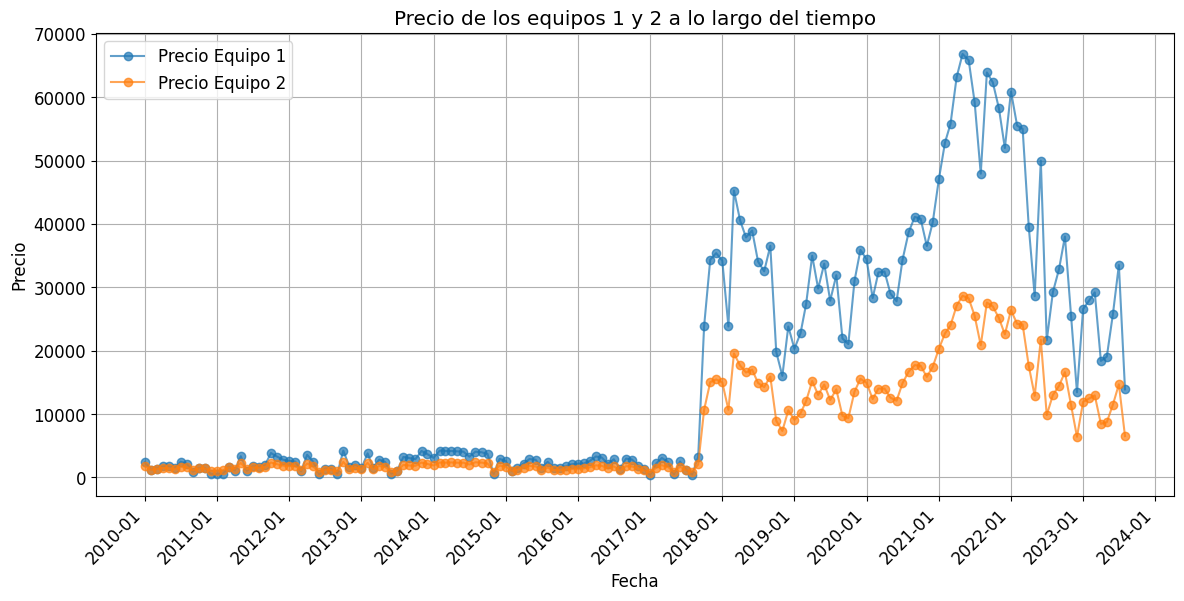

In [ ]:

#arregla el formato de la columna date
df_merged["Date"] = pd.to_datetime(df_merged["Date"])

plt.figure(figsize=(12, 6))

# se imprimen con las fechas
plt.plot_date(df_merged["Date"], df_merged['Equipo_1'], linestyle='-', marker='o',  alpha=0.7, label="Precio Equipo 1")
plt.plot_date(df_merged["Date"], df_merged["Equipo_2"], linestyle='-', marker='o', alpha=0.7, label="Precio Equipo 2")

plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid()

# Se asigna al eje x solo los primeros meses de cada mes:
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Tick every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Format as 'Year-Month'

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.rcParams.update({'font.size': 12})
plt.title("Precio de los equipos 1 y 2 a lo largo del tiempo")
plt.show()

In [ ]:
df_merged_e1= df_merged.drop(columns=["Equipo_2","avg_price_X","avg_price_Y","avg_price_Z"])
df_merged_e2= df_merged.drop(columns=["Equipo_1","avg_price_X","avg_price_Y","avg_price_Z"])
df_merged_e1.sample(5)

,Date,Equipo_1
67,2015-08-01,2462.022095
147,2022-04-01,39570.263400
111,2019-04-01,34997.144762
151,2022-08-01,29238.147391
14,2011-03-01,1721.890870


## Definición de las funciones necesarias para el modelo
Se contemplan aqui las siguientes funciones.
* temporal_split: Divide el conjunto de datos en conjuntos de entrenamiento y prueba
* temporal_window: Convierte una serie temporal en matrices con ventanas
* train_time_series_mlp: Entrena un modelo con una búsqueda de hiperparámetros
* predict_n_future_values: Predice los próximos n valores utilizando un modelo entrenado

In [ ]:
def temporal_split(series, p):
  """
  Separa una serie de tiempo en un conjunto de entrenamiento y prueba temporalmente.
  Entradas:
    series : Arreglo de NumPy con shape (n,) con la serie de tiempo.
    p :porcentaje de datos destinados para la partición de prueba
  Retorna:
    series_train: Arreglo de NumPy con partición de entrenamiento de la serie de tiempo.
    series_test: Arreglo de NumPy con partición de prueba de la serie de tiempo.
  """

  n=round(len(series)*(1-p))
  series_train = series[:n]
  series_test = series[n:]


  return series_train, series_test

In [ ]:
df_merged_e1.iloc[:,1]

,Equipo_1
0,2402.402600
1,1226.558000
2,1413.029739
3,1733.531714
4,1746.256667
...,...
159,18398.273789
160,19073.330261
161,25821.468455
162,33521.784381


Usaremos una red neuronal (perceptrón multicapa) para el entrenamiento. la función train_time_series_mlp entrena y retorna un objeto GridSearchCV como resultado de la exploración de hiperparámetros del regresor perceptrón multicapa. Para garantizar la reproducibilidad de su resultado, se le entregará además el argumento seed, que se usa como semilla aleatoria en el entrenamiento del regresor (en el constructor del regresor base).

In [ ]:

def train_time_series_mlp(X_train, y_train, param_grid, k,seed = 30303):
  """
  Entradas:
    X_train: Arreglo de numpy con shape (n, m)
    y_train: Arreglo de numpy con shape (n,)
    param_grid: Hiperparámetros a explorar
    k: Número de divisiones para TimeSeriesSplit.
    seed: Semilla aleatoria para la creación de la partición.
  Retorna:
    gsearch: GridSearchCV entrenado con X_train y y_train.
  """

  # Declare el regresor base del modelo perceptrón multicapa.
  # IMPORTANTE: Fije la seed aleatoria con el argumento 'random_state'.

  mlp = neural_network.MLPRegressor(random_state=seed)
  # Declare y entrene el objeto GridSearchCV.
  tss=model_selection.TimeSeriesSplit(n_splits=k)
  gsearch = model_selection.GridSearchCV(mlp, param_grid, cv=tss)
  gsearch.fit(X_train, y_train)

  return gsearch

Con el mejor regresor entrenado podemos empezar a realizar predicciones de los próximos precios de los equipos. Para esto, utilizamos una ventana de valores previos para indicarle a nuestro regresor el estado previo de la serie de tiempo y poder obtener la predicción del siguiente valor.

In [ ]:
def temporal_window(series, w):
  """
  Recibe una serie de tiempo series y genere una matriz con las ventanas de tiempo de tamaño w en formato X, y.
  Entradas:
    series: Arreglo de NumPy con tamaño (n,), una serie de tiempo
    w: Número entero, tamaño de las ventanas de tiempo.
  Retorna:
    X: Arreglo de NumPy con shape(n - w, w), las ventanas temporales.
    y: Arreglo de NumPy con shape(n - w,), el valor siguiente en la serie para cada ventana.
  """
  # Select only the numeric column ('Equipo_1') for windowing
  series_values = series.iloc[:,1].values.flatten()
  X = np.empty((len(series_values) - w, w))
  y = np.empty(len(series_values) - w)
  for i in range(len(series_values) - w):
    X[i] = series_values[i:i + w]  # Assigning the windowed values
    y[i] = series_values[i + w]  # Assigning the target value
  return X, y

Ahora vamos a explorar los hiperparámetros de la red para identificar sus valores más apropiados. Para hacer esto, utilizaremos todas las particiones generadas por TimeSeriesSplit y exploraremos manualmente las combinaciones de hiperparámetros de MLPRegressor.

In [ ]:
def next_value(model, window):
  """
  Entradas:
    model: modelo de regresión de Scikit-Learn entrenado.
    window: arreglo de NumPy con shape (w,) donde w es el tamaño de la ventana.
  Retorna:
    next: el valor de la predicción con el siguiente valor a la ventana.
  """
  next = model.predict(window.reshape(1,-1))[0]

  ### FIN DEL CÓDIGO ###
  return next

Para finalizar, realizaremos una predicción de  n  valores futuros de manera autorregresiva (a partir de ventanas predichas por el modelo) y lo compararemos de manera gráfica con la partición de prueba.

In [ ]:
def predict_n_future_values(model, window, n):
  """
  Entradas:
    model: modelo de regresión entrenado con w características de entrada.
    window: arreglo de NumPy con tamaño (w,)
    n:número de pasos temporales a predecir.
  Retorna:
    pred: arreglo de NumPy con tamaño (n,) con la predicción de los siguientes n valores
  """
  pred=np.array([])
  for i in range(n):
    pred=np.append(pred,next_value(model,window))
    window=np.delete(window,0)
    window=np.append(window,pred[i])

  return pred

## Implementación de las funciones e implementacion del modelo.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


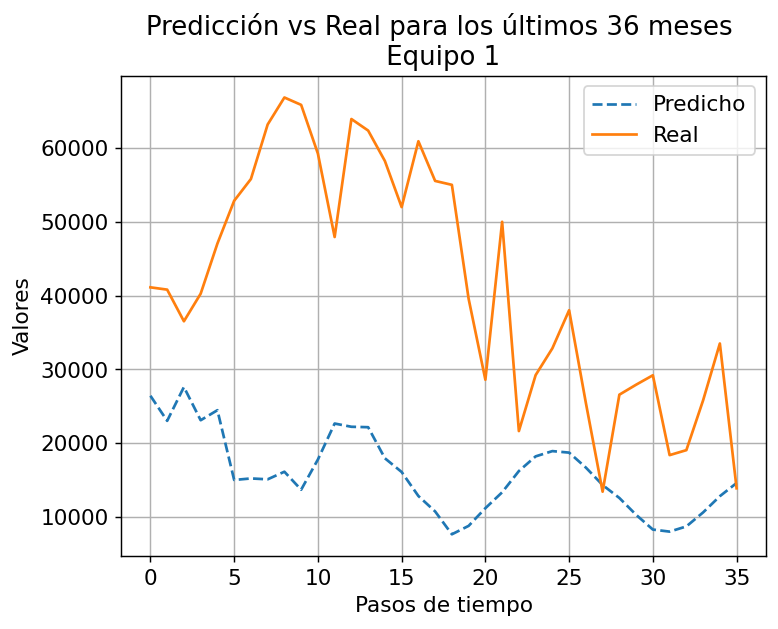

In [ ]:
# Definir el tamaño de la ventana y el horizonte de predicción
window_size = 12  # Tamaño de la ventana temporal
n = 36  # Número de meses a predecir

# Suponiendo que las siguientes funciones y datos están predefinidos:
# - temporal_split: Divide el conjunto de datos en conjuntos de entrenamiento y prueba
# - temporal_window: Convierte una serie temporal en matrices con ventanas
# - train_time_series_mlp: Entrena un modelo con una búsqueda de hiperparámetros
# - predict_n_future_values: Predice los próximos n valores utilizando un modelo entrenado
# - df_merged_e1: El conjunto de datos con el que se trabaja

# Paso 1: Generar particiones de entrenamiento y prueba
X_train, X_test = temporal_split(df_merged_e1, p=0.3)

# Paso 2: Transformar la serie temporal en ventanas de tiempo
X_train_window, y_train_window = temporal_window(X_train, window_size)
X_test_window, y_test_window = temporal_window(X_test, window_size)

# Paso 3: Entrenar el modelo con la búsqueda de hiperparámetros
param_grid = {
    "hidden_layer_sizes": [(40,), (80,)],
    "max_iter": [500],
    "solver": ["adam"],
    "activation": ["relu"]
}

gsearch = train_time_series_mlp(X_train_window, y_train_window, param_grid, 3)

# Paso 4: Usar la última ventana del conjunto de prueba para la predicción
last_window = X_test_window[-1]  # Seleccionar dinámicamente la última ventana

# Paso 5: Obtener los valores reales de los últimos n meses
y_true = y_test_window[-n:]  # Últimos n valores reales

# Paso 6: Predecir los próximos n valores usando el modelo entrenado
y_pred = predict_n_future_values(gsearch, last_window, n)

# Paso 7: Graficar las predicciones y los valores reales
plt.figure(dpi=130)
plt.plot(y_pred, label="Predicho", linestyle="--",)
plt.plot(y_true, label="Real", linestyle="-")
plt.legend()
plt.title("Predicción vs Real para los últimos 36 meses \n Equipo 1 ")
plt.xlabel("Pasos de tiempo")
plt.ylabel("Valores")
plt.grid(True)
plt.show()


Se implemeta de la misma forma para el equipo 2.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


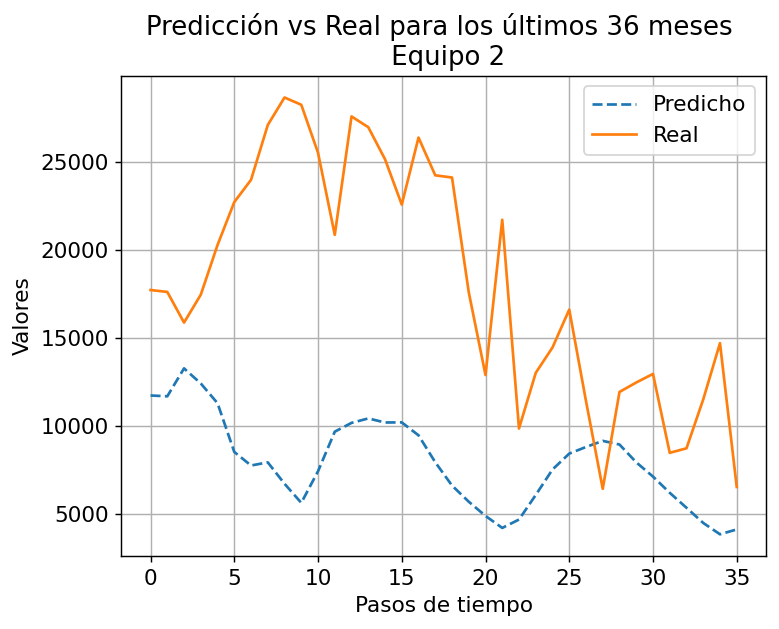

In [ ]:
# Paso 1: Generar particiones de entrenamiento y prueba
X_train, X_test = temporal_split(df_merged_e2, p=0.3)

# Paso 2: Transformar la serie temporal en ventanas de tiempo
X_train_window, y_train_window = temporal_window(X_train, window_size)
X_test_window, y_test_window = temporal_window(X_test, window_size)

# Paso 3: Entrenar el modelo con la búsqueda de hiperparámetros
param_grid = {
    "hidden_layer_sizes": [(40,), (80,)],
    "max_iter": [500],
    "solver": ["adam"],
    "activation": ["relu"]
}

gsearch = train_time_series_mlp(X_train_window, y_train_window, param_grid, 3)

# Paso 4: Usar la última ventana del conjunto de prueba para la predicción
last_window = X_test_window[-1]  # Seleccionar dinámicamente la última ventana

# Paso 5: Obtener los valores reales de los últimos n meses
y_true = y_test_window[-n:]  # Últimos n valores reales

# Paso 6: Predecir los próximos n valores usando el modelo entrenado
y_pred = predict_n_future_values(gsearch, last_window, n)

# Paso 7: Graficar las predicciones y los valores reales
plt.figure(dpi=130)
plt.plot(y_pred, label="Predicho", linestyle="--")
plt.plot(y_true, label="Real", linestyle="-")
plt.legend()
plt.title("Predicción vs Real para los últimos 36 meses \n Equipo 2")
plt.xlabel("Pasos de tiempo")
plt.ylabel("Valores")
plt.grid(True)
plt.show()
